# Geo-Clustering

Here we group contestant's by region. We use "Economic Area Groupings" provided by the FCC (http://transition.fcc.gov/oet/info/maps/areas/). 

![Image of EAG](eag1.png)

In [11]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from pyquery import PyQuery as pq
from bs4 import BeautifulSoup
import requests
import json
from geopy import geocoders
import math
from mpl_toolkits.basemap import Basemap


In [2]:
#Import seasonsDict.json which contains hometown information
#This comes from the Wikipedia Scrape
with open("tempdata/listAllDicts.json") as json_file:
    seasons = json.load(json_file)


Here get the hometown information from each candidate

In [3]:
#Make a function that get's contestant's hometown for a given season
#Update known errors in the dictionary
def get_hometowns(choose_season):
    town_dict = {}
    for idict in seasons:
        if idict["season"] == choose_season:
            if idict["elimination"] == "bachelor":
                bachtown = idict["hometown"]
            else:
                if idict["name"] == "Kacie Boguskie":
                    idict["hometown"] = "Clarksville, Tennessee"
                elif idict["name"] == "Shira Astrof":
                    idict["hometown"] = "Massapequa Park, New York"
                town_dict.update({idict['name']:idict['hometown']})
    return bachtown, town_dict


Open a text file from http://transition.fcc.gov/oet/info/maps/areas/data/2000/FCCCNTY2K.txt. Pare list down just to States, EAG.


In [4]:
#Open FCC text file
fcc = pd.read_csv("FCCCNTY2K.csv")

#Retrieve EAG codes
state_codes = fcc.groupby("STATE").first()
eag = dict(state_codes["EAG_220"])


To convert hometowns in (city, state) format, we use the python package "geopy" which accepts input in our format, and returns the lat/lon coordinates of the center of town. 

In [5]:
#Make function that matches contestants' hometown/state to EAG code
def get_eag(season_num):
    bhome, hometowns = get_hometowns(season_num)

    states = [ss.split(",")[1][1:] for ss in hometowns.values()]
    cnames = hometowns.keys()

    eag_vals = []
    for state in states:
        try:
            eag_vals.append(eag[state])
        except:
            #If contestant is foreign - add a 7th category
            eag_vals.append(7)

    out_dict = dict(zip(cnames, eag_vals))

    return out_dict

Run over all seasons and save the output as a dictionary

In [6]:
season_nums = range(13,20)

#Run over all seasons
geo_dict = {}
for season_num in season_nums:
    geo_dict.update({season_num: get_eag(season_num)})
    print "season ", season_num, " done"


season  13  done
season  14  done
season  15  done
season  16  done
season  17  done
season  18  done
season  19  done


In [7]:
with open('geo_cluster.json', 'w') as fp:
    json.dump(geo_dict, fp)

# Visualization

Here we plot each contestant's hometown lat/lon location, and color by EAG cluster.

In [8]:
with open("geo_cluster.json") as json_file:
    geo_cluster = json.load(json_file)
    
with open("grid_dict.json") as json_file:
    grid_dict = json.load(json_file)
    

In [9]:
def plot_contestant_distribution(use_season):
    cluster = geo_cluster[str(use_season)]
    grid = grid_dict[str(use_season)]

    map = Basemap(projection='merc',\
        resolution = 'l', area_thresh = 100,\
        llcrnrlon=-130, llcrnrlat=20,\
        urcrnrlon=-60, urcrnrlat=55)

    map.drawmapboundary()
    map.fillcontinents(color = 'lightgrey')

    colors = dict(zip(range(1,8), ['b', 'g', 'r', 'c', 'y', 'm', 'k']))
    for coords in grid.keys():
        x,y = map(grid[coords][1], grid[coords][0])
        map.plot(x,y, color=colors[cluster[coords]], marker="o", markersize=25)

    plt.title("USA Distribution of Contestants: Season "+str(use_season))
    plt.show()

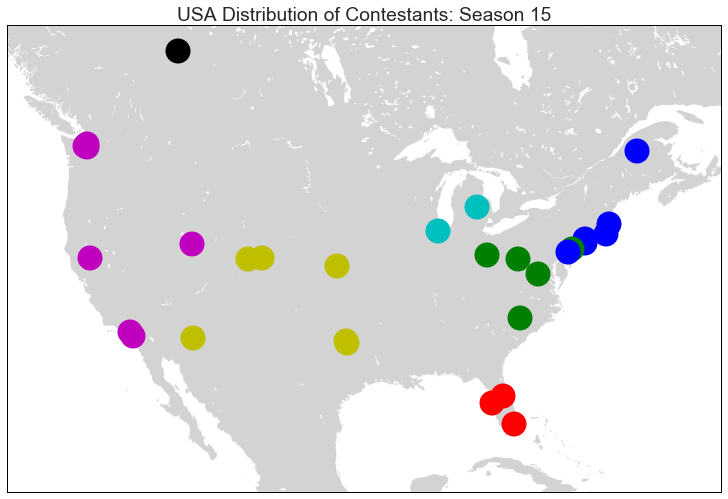

In [12]:
plot_contestant_distribution(15)

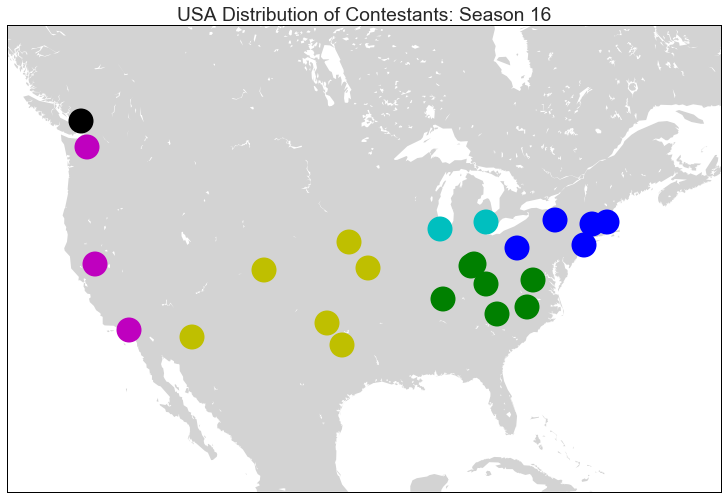

In [13]:
plot_contestant_distribution(16)

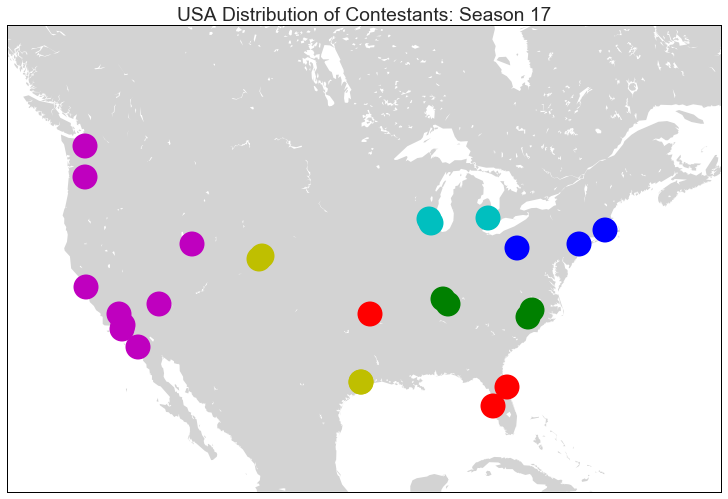

In [14]:
plot_contestant_distribution(17)

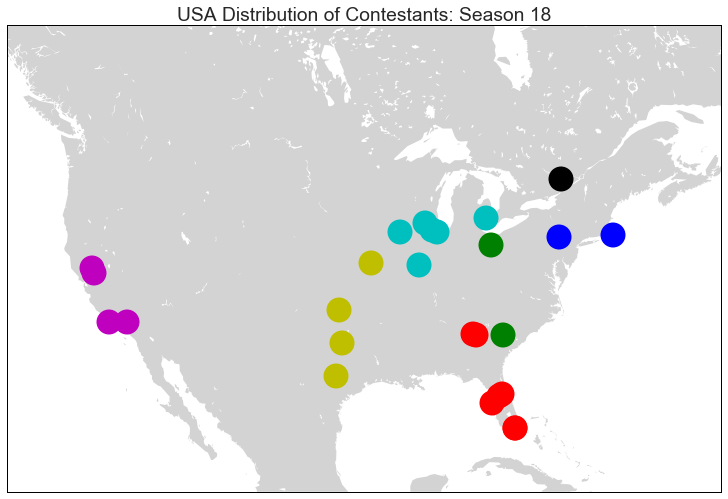

In [15]:
plot_contestant_distribution(18)

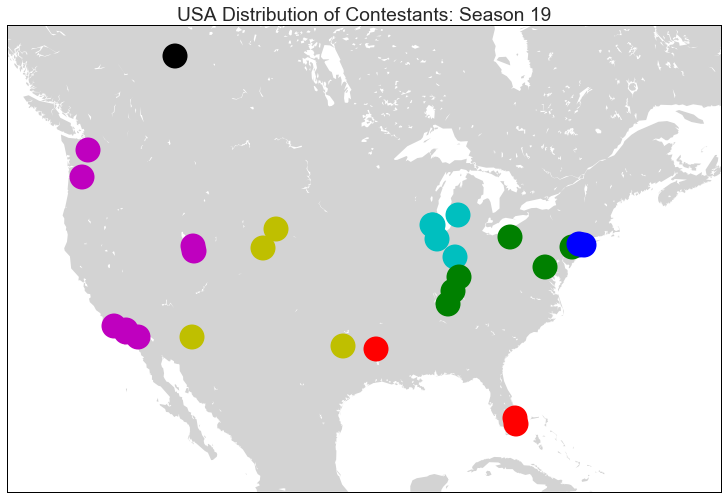

In [16]:
plot_contestant_distribution(19)

We see that the casting agents for the Bachelor tend to favor an even distribution of candidates across the U.S. Some seasons disfavor certain regions, e.g. Season 16 has no Southern contestants, but generally the distribution seems even, making this a balanced predictor to use in a later statistical classifier.